<a href="https://colab.research.google.com/github/eunhyechoe/psyc60/blob/main/2_ISC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2. Intersubject Correlation (ISC) Analysis**


*Lastly Updated: Oct 13 (1:28 AM)*

#### 1. Setup environment, import libraries, and load searchlight indices

As mentioned in the previous tutorial, Colab refreshes its environment each time, so we need to prepare for data analysis again. Just like last time, let’s install several packages, including `neuroboros`, and load the necessary libraries and searchlight indices.

In [1]:
# cell 1
# start and install neuroboros
%%capture
%pip install -U neuroboros hyperalignment

UsageError: Line magic function `%%capture` not found.


In [3]:
# cell 2
# import libraries
import numpy as np
import neuroboros as nb
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, cdist, squareform
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [4]:
# cell 3
# load searchlight indices for ico8 right hemisphere (607 searchlights, 9666 vertices)
## rh, radii = 10 mm, 15, and 20 mm
SLS_ico8_10mm_rh = nb.sls('r', 10, space='onavg-ico32', center_space='onavg-ico8', return_dists=False)
SLS_ico8_15mm_rh = nb.sls('r', 15, space='onavg-ico32', center_space='onavg-ico8', return_dists=False)
SLS_ico8_20mm_rh, Dists_ico8_20mm_rh = nb.sls('r', 20, space='onavg-ico32', center_space='onavg-ico8', return_dists=True)
# sls function input variables: ('hemisphere', radius, vertex space, center space, option to load file of distances from center to each vertex)

### 2. Load a multi-subject dataset

In this tutorial, we will perform an intersubject correlation analysis using data from multiple participants. As we practiced last time, let's use the `forrest` dataset provided by `neuroboros` to load a multiple-subject dataset.

In [5]:
# define data first
dset = nb.Forrest()
sids = dset.subjects

In [6]:
sids

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '09',
 '10',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20']

In [7]:
# Part II, ISC, cell 1
# upload multisubject data (five brains, right hemisphere for first run)
# dm5 is a data matrix with brains, timepoints, and vertices as dimensions [5,451,9666]
#dm5 = np.zeros((5,451,9666))
#for subj in range(5):
#  sid = sids[subj]
#  dm5[subj,:,:] = dset.get_data(sid, 'forrest', 1, 'r')
# (subject id, 'dataset', run, 'hemisphere')

 Since loading the entire dataset (i.e. `for subj in range(20)`) would take too much time, we will practice using data from just three participants.

In [9]:
dm = np.zeros((3,451,9666))
for subj in range(3):
 sid = sids[subj]
 dm[subj,:,:] = dset.get_data(sid, 'forrest', 1, 'r')

### 3. Calculate ISC for all indiviadual pairs, all vertices



#### (1) Load dataset

In [10]:
dm.shape

(3, 451, 9666)



The multisubject data matrix we've loaded has a structure of `[subject, timepoint, vertices]`. We will calculate the intersubject correlation coefficient for each of the 9666 vertices that make up the data points of the right hemisphere. Let's see if we can observe significant intersubject correlation for specific vertex across time.

Since we need to repeat the calculation for all vertices, we will use a `for vertex in range(9666)` loop.

In [13]:
# Part II, ISC, cell 2 copy
# calculate ISC pairwise
ISCs = np.zeros((3,3,9666))
for vtx in range(9666):
  ISCs[:, :, vtx] = np.corrcoef(dm[:, :, vtx])
  ISCs_clean = ISCs # copy ISCs to make a clean version
  ISCs_clean[np.isnan(ISCs)] = 0 # clean up not-a-number cells

Therefore, each vertex will have 3x3 correlation matrix for three participants.

In [14]:
ISCs.shape

(3, 3, 9666)

#### (2) Calculate mean ISC across pairs
Now, let's calculate mean of intersubject correlation, across all possible pairs (of subjects). Since you have a 3x3 matrix for each vertex, you need to exclude the 3 diagonal elements (self-correlations) and calculate the average of the 6 off-diagonal elements (pairwise correlations between the 3 subjects).

In [16]:
# Part II, ISC, cell 2
## calculate mean ISCs to show brain map
ISCs_mean = (np.sum(ISCs_clean, axis = (0,1))-3)/6
print("max ISC =", np.max(ISCs_mean))

max ISC = 0.6529441046341343


#### (3) Plot brain image of ISCs
You can plot ISCs as brain images. Don't forget to set the maximum ISC value as the plot's maximum value.

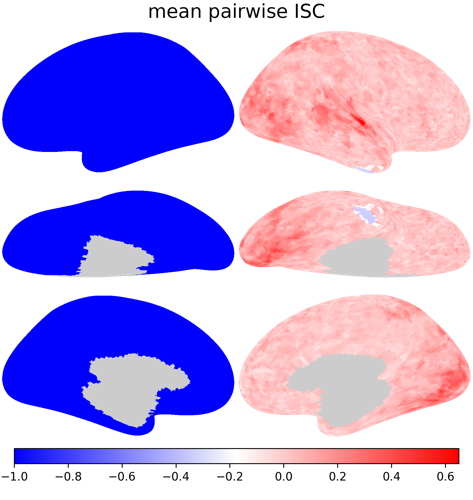

In [18]:
# Part II, ISC, cell 3
## plot mean pairwise ISCs
lh_minus_one = np.zeros((9675))-1
nb.plot([lh_minus_one, ISCs_mean], cmap='bwr', vmax=0.65, vmin=-1, title='mean pairwise ISC')


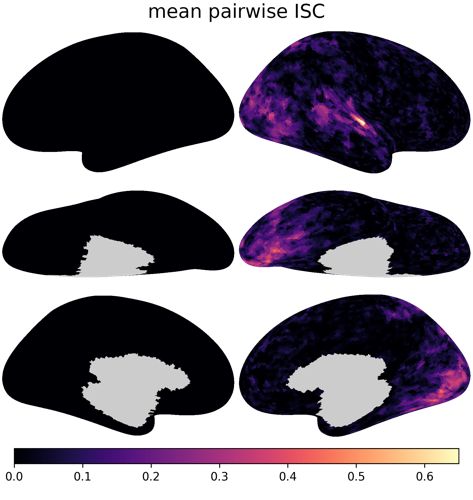

In [21]:
# plot positive values only
lh_zero = np.zeros((9675))
nb.plot([lh_zero, ISCs_mean], cmap='magma', vmax=0.65, vmin=0, title='mean pairwise ISC')

In [ ]:
# # Part II, ISC, cell 2 alternate
# # calculate ISC pairwise
# ISCs = np.zeros[5,5,9666]
# for subj in range(5):
#   for subj in range(5):
#     for vtx in range(9666):
#       ISCs[subj1, subj2, vtx] = np.corrcoef(dm5[subj1, :, vtx], dm5[subj2, :, vtx])[0,1]

### 4. Calculate ISCs for searchlight



Let's calculate the intersubject correlation (ISC) for each searchlight, focusing on the brain activity of the vertices within each searchlight for each time point, rather than individual vertices across time. For this exercise, we will use ico8 searchlights with a radius of 15mm. The ico8 space provides a total of 607 searchlights.

In [26]:
len(SLS_ico8_15mm_rh)

607

#### (1) Calculate searchlight means
However, before calculating ISC, we first need to compute the average activity of the vertices within each searchlight for each timeseries, as we focus on searchlights rather than individual vertices. `sl_means` will have the structure `[subject, timeseries, searchlight]`.

In [27]:
# Part II, ISCs, calculate ISCs of searchlight time-series
## calculate sl means
sl_means = np.zeros((3,451,len(SLS_ico8_10mm_rh)))
for sl in range(len(SLS_ico8_15mm_rh)):
  sl_means[:,:,sl] = np.mean(dm[:,:,SLS_ico8_15mm_rh[sl]], axis = 2)

In [28]:
sl_means.shape

(3, 451, 607)

#### (2) Calculate ISCs
Let's see if the brain activity within each searchlight correlates across time!

In [40]:
# calculate coarse ISCs
ISCs_ico8 = np.zeros((3,3,607))
for sl in range(607):
  ISCs_ico8[:, :, sl] = np.corrcoef(sl_means[:, :, sl])
  ISCs_ico8_clean = ISCs_ico8
  ISCs_ico8_clean[np.isnan(ISCs_ico8)] = 0

In [41]:
# Part II, ISC, cell 2
## calculate mean searchlight ISCs to show brain map
ISCs_mean = (np.sum(ISCs_ico8_clean, axis = (0,1))-3)/6
print("max ISC =", np.max(ISCs_mean))

max ISC = 0.5857528193462688


#### (3) Plot brain image of ISCs

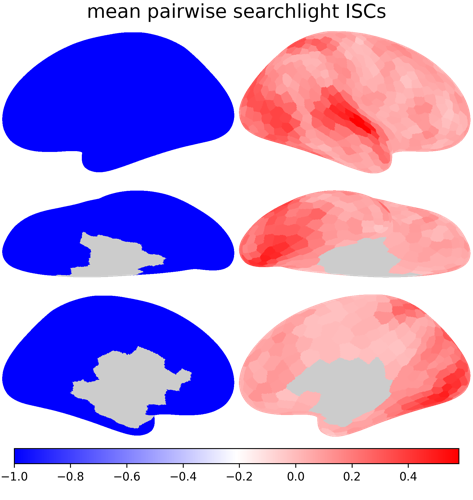

In [42]:
## plot mean pairwise ISCs
lh8_minus_one = np.zeros((603))-1
nb.plot([lh8_minus_one, ISCs_mean], cmap='bwr', vmax=0.58, vmin=-1, title='mean pairwise searchlight ISCs')


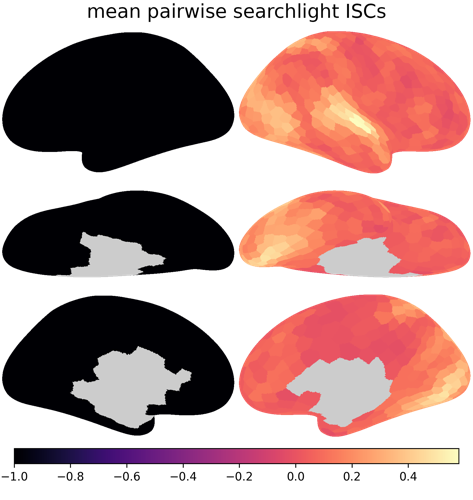

In [43]:
lh8_zero = np.zeros((603))-1
nb.plot([lh8_zero, ISCs_mean], cmap='magma', vmax=0.58, vmin=-1, title='mean pairwise searchlight ISCs')


### 5. Compare multisubject dataset

#### (1) Compare brain activity between subjects across timeseries

Text(0.5, 1.0, 'TTT')

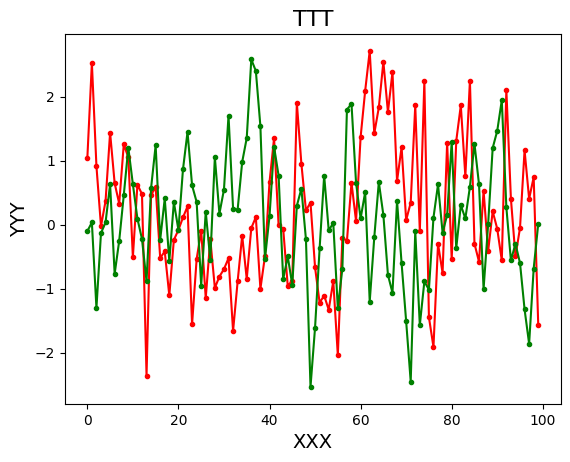

In [45]:
# Part II, ISC, cell 3 & 4
## plot line graph of two vertex time-series from different brains
## FFA center vertex is 6579 in ico32 and 262 in ico8
b1 = 0
b2 = 1
time_series1 = dm[b1,100:200,6579]
time_series2 = dm[b2,100:200,6579]
plt.plot(time_series1, "r.-")
plt.plot(time_series2, "g.-")
plt.xlabel("XXX", fontsize=14)
plt.ylabel("YYY", fontsize =14)
plt.title("TTT", fontsize=16)

#### (2) Compare brain activity within searchlight between subjects

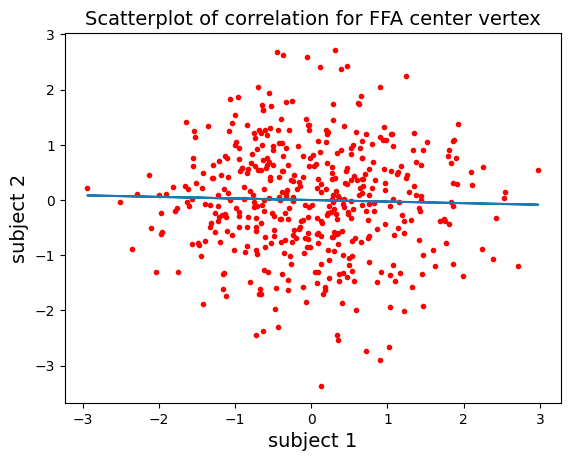

In [46]:
# cell 5
## plot scatter plot for ISC for one vertex with regression line
plt.plot(dm[b1,:,6579], dm[b2,:,6579], 'r.')  # make scatterplot
m, b = np.polyfit(dm[b1,:,6579], dm[b2,:,6579], 1)  # calculate linear regression
plt.plot(dm[b1,:,6579], m*dm[b1,:,6579] + b)  # plot regression line
plt.xlabel("subject 1", fontsize=14)
plt.ylabel("subject 2", fontsize =14)
plt.title("Scatterplot of correlation for FFA center vertex", fontsize=14)
plt.show()


In [48]:
ISCs_mean[262] # should be ico8 vertice

0.2151494342564746

In [ ]:
# # data for subject 1 and 2 (Python starts label with 0)
# dm1 = dset.get_data(sids[0], 'forrest', 1, 'lr')
# dm2 = dset.get_data(sids[1], 'forrest', 1, 'lr')

In [ ]:
# print(dm1.shape, dm2.shape)

(451, 19341) (451, 19341)


In [ ]:
# # number of timeseries/vertices
# nt, nv = dm1.shape
# print(nt, nv)

451 19341


In [ ]:
# # compute Pearson R correlation between two subjects, for all vertices
# isc = np.zeros((nv,))
# for i in range(nv):
#     isc[i] = pearsonr(dm1[:, i], dm2[:, i])[0]

<ipython-input-10-e9037f152eec>:4: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  isc[i] = pearsonr(dm1[:, i], dm2[:, i])[0]


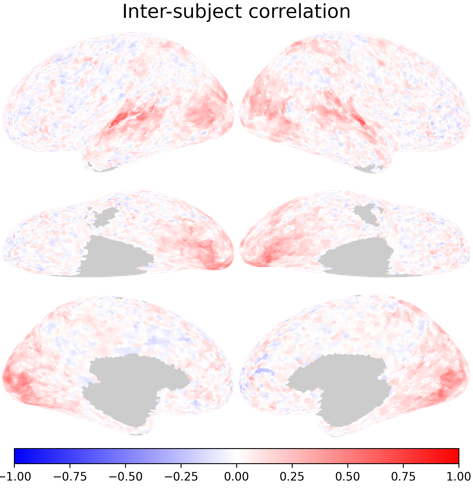

In [ ]:
# nb.plot(isc,
#         title='Inter-subject correlation',
#         vmax=1, vmin=-1, cmap='bwr')

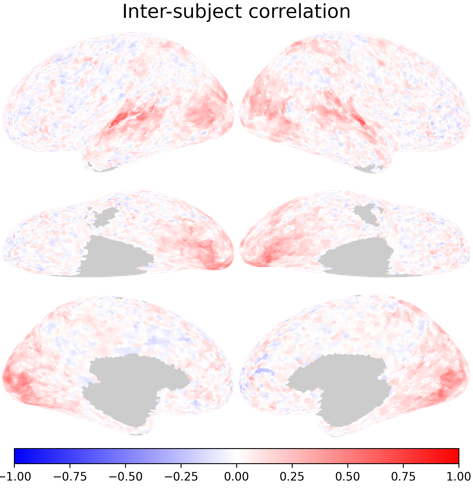

In [ ]:
# nb.plot(isc2,
#         title='Inter-subject correlation',
#         vmax=1, vmin=-1, cmap='bwr')

In [ ]:
# # or calculate z-score
# isc2 = np.mean(
#     zscore(dm1, axis=0) * zscore(dm2, axis=0),
#     axis=0)

In [ ]:
# np.testing.assert_allclose(isc, isc2)

In [ ]:
# # load all of them
# dms = [dset.get_data(sid, 'forrest', 1, 'lr')
#        for sid in sids]
# dms = np.stack(dms, axis=0)

In [ ]:
# dms.shape